In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
random_seed = 42
torch.manual_seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
np.random.seed(random_seed)
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'ARRG')))
from ARRG_macro import *

import wasserstein_loss
import deepsets_classifier
import importlib
importlib.reload(wasserstein_loss)
importlib.reload(deepsets_classifier)
from wasserstein_loss import *
from deepsets_classifier import *

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

## Deepsets Classifier

In [3]:
# Paths to the datasets on perlmutter
exp_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
#exp_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_accept_reject_z_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
sim_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e6.npy'
sim_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_finalTwo_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'
sim_fPrel_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_finalTwo_fPrel_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'

# Load the arrays
exp_hadrons       = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons       = np.load(sim_hadrons_PATH, mmap_mode="r")

# Extract the hadron multiplicity
N=100000
exp_mult = np.array([len(exp_hadrons[i,:][np.abs(exp_hadrons[i,:,0]) > 0.0]) for i in range(N)])
sim_mult = np.array([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(N)])
min_mult = min(exp_mult.min(), sim_mult.min())
max_mult = max(exp_mult.max(), sim_mult.max())
print("Max multiplicity:", max_mult)
exp_hadrons = exp_hadrons[:, :max_mult, :]
sim_hadrons = sim_hadrons[:, :max_mult, :]

# Extract (px, py, pz)
px_exp, py_exp, pz_exp = exp_hadrons[..., 0], exp_hadrons[..., 1], exp_hadrons[..., 2]
px_sim, py_sim, pz_sim = sim_hadrons[..., 0], sim_hadrons[..., 1], sim_hadrons[..., 2]
# Create masks for non-zero momentum entries
mask_exp = (px_exp != 0) | (py_exp != 0) | (pz_exp != 0)
mask_sim = (px_sim != 0) | (py_sim != 0) | (pz_sim != 0)

# Calculate transverse momentum (pT)
pt_exp = np.sqrt(px_exp**2 + py_exp**2)
pt_sim = np.sqrt(px_sim**2 + py_sim**2)

# Initialize arrays for the results with zeros
phi_exp = np.zeros_like(pt_exp)
phi_sim = np.zeros_like(pt_sim)
eta_exp = np.zeros_like(pt_exp)
eta_sim = np.zeros_like(pt_sim)

# Apply the calculations only where the mask is True (non-zero momentum)
phi_exp[mask_exp] = np.arctan2(py_exp[mask_exp], px_exp[mask_exp])
phi_sim[mask_sim] = np.arctan2(py_sim[mask_sim], px_sim[mask_sim])

theta_exp = np.arctan2(pt_exp[mask_exp], pz_exp[mask_exp])
theta_sim = np.arctan2(pt_sim[mask_sim], pz_sim[mask_sim])

eta_exp[mask_exp] = -np.log(np.tan(theta_exp / 2))
eta_sim[mask_sim] = -np.log(np.tan(theta_sim / 2))
# New observable: (pT, phi, eta)
exp_obs = np.stack([pt_exp, phi_exp, eta_exp], axis=-1)
sim_obs= np.stack([pt_sim, phi_sim, eta_sim], axis=-1)
# Print dataset shapes
print('Experimental observable shape:', exp_obs.shape)
print('Simulated observable shape:', sim_obs.shape)

# Restrict to a subset of the full dataset (for memory)

def prescale(exp_data, sim_data, axes=(0, 1)):
    # Mask to identify non-padded entries (i.e., entries that are not [0.0, 0.0, 0.0, 0.0])
    non_padded_mask_exp = ~(np.all(exp_data == 0, axis=-1))
    non_padded_mask_sim = ~(np.all(sim_data == 0, axis=-1))
    
    # Flatten the non-padded parts of the datasets along the specified axes for mean/std calculation
    combined_data = np.concatenate([exp_data[non_padded_mask_exp], sim_data[non_padded_mask_sim]], axis=0)
    combined_mean = combined_data.mean(axis=0)
    print("Mean:", combined_mean)
    combined_std = combined_data.std(axis=0)

    # Scale only the non-padded entries using the combined mean and std
    exp_data_scaled = np.copy(exp_data)
    sim_data_scaled = np.copy(sim_data)
    exp_data_scaled[non_padded_mask_exp] = (exp_data[non_padded_mask_exp] - combined_mean) / combined_std
    sim_data_scaled[non_padded_mask_sim] = (sim_data[non_padded_mask_sim] - combined_mean) / combined_std
    
    return exp_data_scaled, sim_data_scaled

N_events = int(100000)
exp_obs, sim_obs = prescale(exp_obs[0:N_events], sim_obs[0:N_events])
# Convert into torch objects
exp_obs = torch.Tensor(exp_obs.copy()).to(device)
sim_obs = torch.Tensor(sim_obs.copy()).to(device)
# Combine and split into training + validation and test sets
train_val_exp_obs, test_exp_obs = train_test_split(exp_obs, test_size=0.1, random_state=random_seed)
train_val_sim_obs, test_sim_obs = train_test_split(sim_obs, test_size=0.1, random_state=random_seed)
# Further split training + validation into separate training and validation sets
train_exp_obs, val_exp_obs = train_test_split(train_val_exp_obs, test_size=0.25, random_state=random_seed)  # 0.25 x 0.8 = 0.2
train_sim_obs, val_sim_obs = train_test_split(train_val_sim_obs, test_size=0.25, random_state=random_seed)

# Prepare data
batch_size=10000
train_exp_loader, train_sim_loader = prepare_data(train_exp_obs, train_sim_obs, batch_size=batch_size)
val_exp_loader, val_sim_loader = prepare_data(val_exp_obs, val_sim_obs, batch_size=batch_size)
test_exp_loader, test_sim_loader = prepare_data(test_exp_obs, test_sim_obs, batch_size=batch_size)

# Print dataset shapes
print('Experimental observable shape:', train_exp_obs.shape)
print('Simulated observable shape:', train_sim_obs.shape)

Max multiplicity: 32
Experimental observable shape: (1000000, 32, 3)
Simulated observable shape: (1000000, 32, 3)
Mean: [ 4.00447096e-01 -1.68188356e-03  3.01965013e-04]
Experimental observable shape: torch.Size([67500, 32, 3])
Simulated observable shape: torch.Size([67500, 32, 3])


Number of learnable parameters: 16961
[0.70279866 0.5455019  0.86343485 0.37372303 0.29915553]


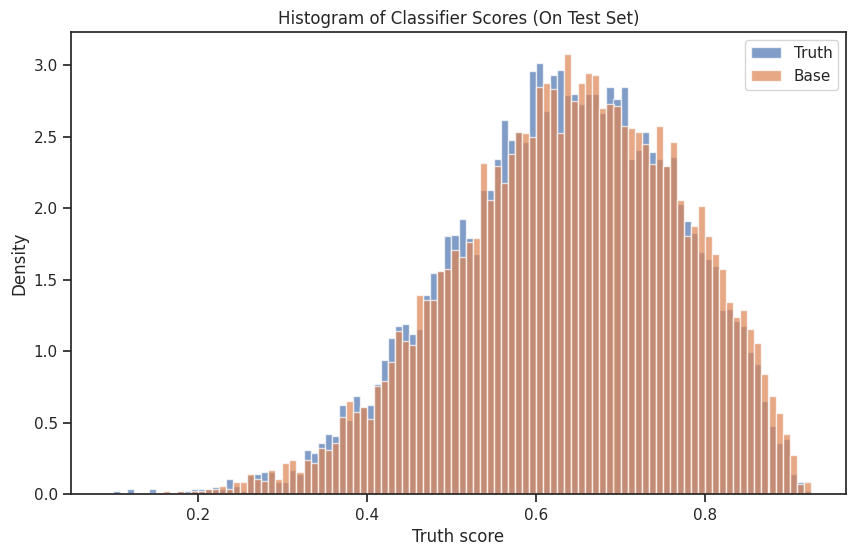

In [67]:
importlib.reload(deepsets_classifier)
from deepsets_classifier import *
torch.manual_seed(random_seed)
np.random.seed(random_seed)
# Usage example:
input_dim = 3
phi_hidden_dim=64
rho_hidden_dim=64
phi_layers=3
rho_layers=3
dropout_prob=0.0
mask_pad=True
classifier = DeepSetsClassifier(input_dim=input_dim, phi_hidden_dim=phi_hidden_dim, rho_hidden_dim=rho_hidden_dim,
                                phi_layers=phi_layers, rho_layers=rho_layers,
                                dropout_prob=dropout_prob, mask_pad=mask_pad).to(device)
load_pretrain=False
if not load_pretrain:
    # Change initial weights
    for m in classifier.modules():
        if isinstance(m, nn.Linear):
            # for full phase space:
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('tanh'))
            #nn.init.kaiming_uniform_(m.weight, a=0.1, mode="fan_in", nonlinearity="leaky_relu") 
            #nn.init.uniform_(m.bias)#,-1.3,1)#, -2, 2)# a=-1, b=0.5) # center at 0.5 if possible

    classifier.eval() # never forget
    print(classifier(test_exp_obs[:5]).cpu().detach().numpy()) # for debugging
    test_exp_scores = torch.sigmoid(classifier(test_exp_obs)).cpu().detach().numpy()
    test_sim_scores = torch.sigmoid(classifier(test_sim_obs)).cpu().detach().numpy()
    plot_score_histogram(test_exp_scores, test_sim_scores, same_bins=True, bins=100)

In [77]:
# Pre-train the classifier on gaussian
pretrain=True
pretrain_filename = "pretrained_deepsets_classifier_3_3_32_3_64_p.pth" # inputdim_philayers_philayersize_...
if pretrain:
    pretraining_epochs = 20
    epochs=0
    lr=1e-4
    classifier.train_classifier(train_exp_loader, train_sim_loader, val_exp_loader, val_sim_loader, 
                                device=device, num_epochs=epochs, learning_rate=lr, pretraining_epochs=pretraining_epochs)
    torch.save(classifier.state_dict(), pretrain_filename)
else:
    classifier.load_state_dict(torch.load(pretrain_filename))

Pretraining epoch [1/0]
Train Loss: 0.052384, Train Exp Loss: 0.05405, Train Sim Loss: 0.05072
Val Loss: 0.0056025, Val Exp Loss: 0.00574, Val Sim Loss: 0.005465


Pretraining epoch [2/0]
Train Loss: 0.051312, Train Exp Loss: 0.05438, Train Sim Loss: 0.04825
Val Loss: 0.0054783, Val Exp Loss: 0.005943, Val Sim Loss: 0.005014


Pretraining epoch [3/0]
Train Loss: 0.04998, Train Exp Loss: 0.05388, Train Sim Loss: 0.04608
Val Loss: 0.0055302, Val Exp Loss: 0.005942, Val Sim Loss: 0.005118


Pretraining epoch [4/0]
Train Loss: 0.049414, Train Exp Loss: 0.05344, Train Sim Loss: 0.04539
Val Loss: 0.0053802, Val Exp Loss: 0.005749, Val Sim Loss: 0.005011


Pretraining epoch [5/0]
Train Loss: 0.048753, Train Exp Loss: 0.05335, Train Sim Loss: 0.04416
Val Loss: 0.005288, Val Exp Loss: 0.00587, Val Sim Loss: 0.004706


Pretraining epoch [6/0]
Train Loss: 0.048231, Train Exp Loss: 0.05295, Train Sim Loss: 0.04351
Val Loss: 0.0052889, Val Exp Loss: 0.005841, Val Sim Loss: 0.004737


Pretraining epoch [7/0]
Train Loss: 0.048523, Train Exp Loss: 0.05372, Train Sim Loss: 0.04333
Val Loss: 0.005379, Val Exp Loss: 0.005965, Val Sim Loss: 0.004793


Pretraining epoch [8/0]
Train Loss: 0.047924, Train Exp Loss: 0.05346, Train Sim Loss: 0.04238
Val Loss: 0.0053963, Val Exp Loss: 0.005976, Val Sim Loss: 0.004816


Pretraining epoch [9/0]
Train Loss: 0.048158, Train Exp Loss: 0.05364, Train Sim Loss: 0.04268
Val Loss: 0.0054063, Val Exp Loss: 0.006251, Val Sim Loss: 0.004562


Pretraining epoch [10/0]
Train Loss: 0.04791, Train Exp Loss: 0.05352, Train Sim Loss: 0.0423
Val Loss: 0.0052867, Val Exp Loss: 0.006151, Val Sim Loss: 0.004422


Pretraining epoch [11/0]
Train Loss: 0.047567, Train Exp Loss: 0.05317, Train Sim Loss: 0.04196
Val Loss: 0.0051134, Val Exp Loss: 0.005611, Val Sim Loss: 0.004616


Pretraining epoch [12/0]
Train Loss: 0.047596, Train Exp Loss: 0.05336, Train Sim Loss: 0.04183
Val Loss: 0.0052475, Val Exp Loss: 0.005904, Val Sim Loss: 0.004591


Pretraining epoch [13/0]
Train Loss: 0.047565, Train Exp Loss: 0.05374, Train Sim Loss: 0.04139
Val Loss: 0.0054134, Val Exp Loss: 0.006196, Val Sim Loss: 0.00463


Pretraining epoch [14/0]
Train Loss: 0.047728, Train Exp Loss: 0.05389, Train Sim Loss: 0.04157
Val Loss: 0.0053346, Val Exp Loss: 0.006259, Val Sim Loss: 0.00441


Pretraining epoch [15/0]
Train Loss: 0.047509, Train Exp Loss: 0.05375, Train Sim Loss: 0.04126
Val Loss: 0.005143, Val Exp Loss: 0.005847, Val Sim Loss: 0.004438


Pretraining epoch [16/0]
Train Loss: 0.047382, Train Exp Loss: 0.05341, Train Sim Loss: 0.04136
Val Loss: 0.005365, Val Exp Loss: 0.006288, Val Sim Loss: 0.004442


Pretraining epoch [17/0]
Train Loss: 0.047669, Train Exp Loss: 0.05355, Train Sim Loss: 0.04179
Val Loss: 0.0053702, Val Exp Loss: 0.005908, Val Sim Loss: 0.004833


Pretraining epoch [18/0]
Train Loss: 0.047596, Train Exp Loss: 0.05375, Train Sim Loss: 0.04145
Val Loss: 0.00527, Val Exp Loss: 0.006005, Val Sim Loss: 0.004535


Pretraining epoch [19/0]
Train Loss: 0.047541, Train Exp Loss: 0.05392, Train Sim Loss: 0.04116
Val Loss: 0.0053753, Val Exp Loss: 0.006003, Val Sim Loss: 0.004748


Pretraining epoch [20/0]
Train Loss: 0.04736, Train Exp Loss: 0.05351, Train Sim Loss: 0.04121
Val Loss: 0.0050707, Val Exp Loss: 0.00584, Val Sim Loss: 0.004301


In [ ]:
classifier.eval()
test_exp_scores = torch.sigmoid(classifier(test_exp_obs)).cpu().detach().numpy()
test_sim_scores = torch.sigmoid(classifier(test_sim_obs)).cpu().detach().numpy()
plot_score_histogram(test_exp_scores, test_sim_scores, same_bins=True, bins=200)
print(test_exp_scores)
#train_exp_scores = torch.sigmoid(classifier(train_exp_obs)).cpu().detach().numpy()
#train_sim_scores = torch.sigmoid(classifier(train_sim_obs)).cpu().detach().numpy()
#plot_score_histogram(train_exp_scores, train_sim_scores, same_bins=True, bins=200)

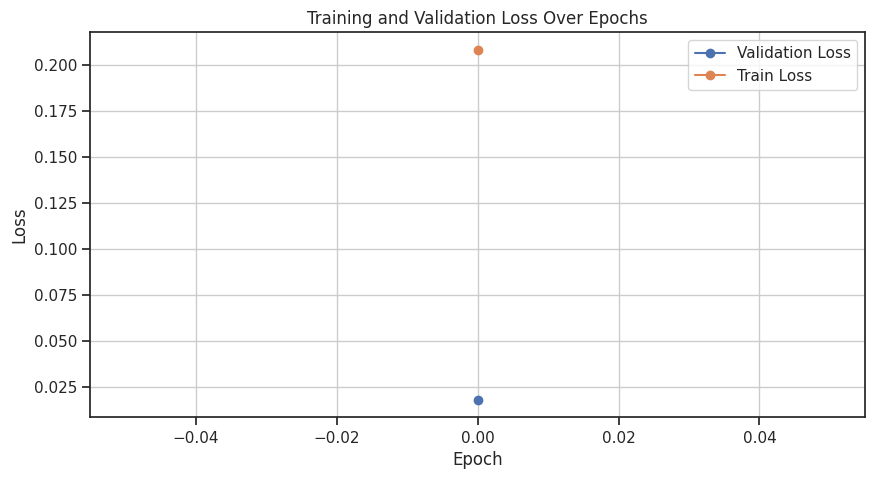

In [70]:
plt.figure(figsize=(10, 5))
#plt.plot(classifier.train_loss[4:], label='Training Loss', marker='o')
# plt.plot(classifier.val_loss, label='Validation Loss', marker='o')
plt.plot(classifier.train_loss, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.show()

## Wasserstein Weight Tuning

In [341]:
#classifier.to('cpu')

sim_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_finalTwo_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'
sim_fPrel_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_finalTwo_fPrel_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'

sim_accept_reject = np.load(sim_accept_reject_PATH, mmap_mode = "r")
sim_fPrel         = np.load(sim_fPrel_PATH, mmap_mode = "r")

N_events = min(len(sim_accept_reject), 100000)
print("N_events:", N_events)
sim_accept_reject = torch.Tensor(sim_accept_reject[0:N_events].copy()).to(device) # z values
# Check the accepted z-values, if z == 1 reduce it by epsilon (a very nasty bug to find).
# The a-coefficient when computing the likelihood has a term propotional to log(1-z). If 
# z = 1, this term diverges to -inf and completely destroys the backward pass.
epsilon = 1e-5
sim_accept_reject[sim_accept_reject == 1] = 1 - epsilon
sim_fPrel = torch.Tensor(sim_fPrel[0:N_events].copy()).to(device)

print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

N_events: 50000
Simulated z shape: torch.Size([50000, 105, 101])
Simulated fPrel shape: torch.Size([50000, 105, 100])


In [342]:
params_base = torch.tensor([0.72, 0.88])
params_init = torch.tensor([0.7, 0.9])
over_sample_factor = 10.0
# initialize weight module
weight_nexus = LundWeight(params_base, params_init, over_sample_factor = over_sample_factor)

n = 10
print(weight_nexus(sim_accept_reject[:n], sim_fPrel[:n]))

tensor([1.0491, 1.1027, 0.9518, 1.1018, 1.0195, 0.8884, 0.8477, 1.0835, 1.0926,
        0.8541], device='cuda:0', grad_fn=<MulBackward0>)


In [343]:
class CombinedDataset(Dataset):
    def __init__(self, exp_obs, sim_obs, sim_fPrel, sim_accept_reject):
        self.exp_obs = exp_obs
        self.sim_obs = sim_obs
        self.sim_fPrel = sim_fPrel
        self.sim_accept_reject = sim_accept_reject
        assert len(exp_obs) == len(sim_obs) == len(sim_fPrel) == len(sim_accept_reject), "All inputs must have the same length"

    def __len__(self):
        return len(self.exp_obs)

    def __getitem__(self, idx):
        return {
            'exp_scores': self.exp_obs[idx],
            'sim_scores': self.sim_obs[idx],
            'sim_fPrel': self.sim_fPrel[idx],
            'sim_accept_reject': self.sim_accept_reject[idx],
        }

# Assuming you've already processed your data as described in your code snippet
# and have exp_obs, sim_obs, sim_accept_reject, and sim_mT ready

# Create the dataset
exp_scores = classifier.forward(exp_obs[:sar_size]).to(device)
sim_scores = classifier.forward(sim_obs[:sar_size]).to(device)
sar_size = sim_accept_reject.shape[0]
dataset = CombinedDataset(exp_scores, sim_scores, sim_fPrel, sim_accept_reject)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))  # 90% for training
val_size = len(dataset) - train_size  # no worry of overfittitng, remove validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 10000  # You can adjust this as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [344]:
# Define a grid of initial parameters
a_range  = (0.6, 0.80)
b_range  = (0.85, 1.05)
n_points = 10
a_b_init = a_b_grid(a_range, b_range, n_points)

In [345]:
params_base = torch.tensor([0.72, 0.88])
params_init = torch.tensor([0.72, 0.881])
# True parameters (0.68, 0.98)
over_sample_factor = 10.0
# initialize weight module

weight_nexus = LundWeight(params_base, params_init, over_sample_factor = over_sample_factor).to(device)
tuner = Wasserstein_Tuner(weight_nexus, learning_rate=0.005)
tuner.train(train_loader, val_loader, num_epochs=10)

Beginning parameter tuning...
Initial (a, b): (0.7200, 0.8810)


LundWeight()

Text(0.5, 1.0, 'Parameters (a,b) over epochs')

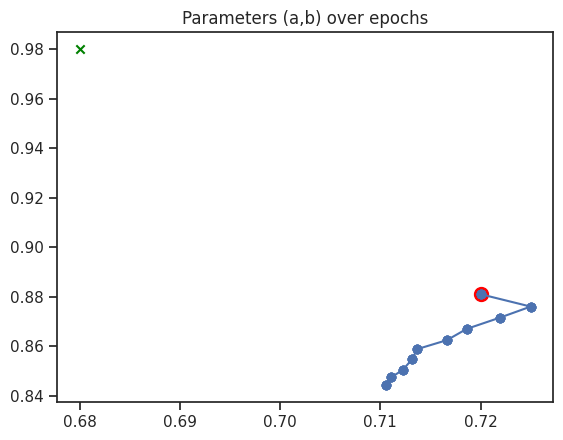

In [346]:
a_history = [p['params_a'] for p in tuner.param_history]
b_history = [p['params_b'] for p in tuner.param_history]
plt.plot(a_history, b_history, marker = 'o')
plt.scatter(params_init[0], params_init[1], marker='o', s=100, color="red", label="Base")
plt.scatter(0.68, 0.98, marker='x', color="green", label="Truth")
plt.title("Parameters (a,b) over epochs")

In [347]:
# Define a grid of initial parameters
a_range  = (0.6, 0.80)
b_range  = (0.85, 1.05)
n_points = 10
a_b_init = a_b_grid(a_range, b_range, n_points)
weight_nexus = LundWeight(params_base, params_init, over_sample_factor = over_sample_factor).to(device)
tuner = Wasserstein_Tuner(weight_nexus, learning_rate=0.005)
a_b_gradients, loss_grid = tuner.Wasserstein_flow(train_loader, a_b_init)

Wasserstein Flow:   1%|▍                                            | 1/100 [00:01<02:10,  1.32s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f40510172f0>>
Traceback (most recent call last):
  File "/global/homes/n/nheller/.conda/envs/herwig_jupyter/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Wasserstein Flow:  60%|██████████████████████████▍                 | 60/100 [01:23<00:54,  1.36s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f40510172f0>>
Traceback (most recent call last):
  File "/global/homes/n/nheller/.conda/envs/herwig_jupyter/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Wasserstein Flow: 100%|█

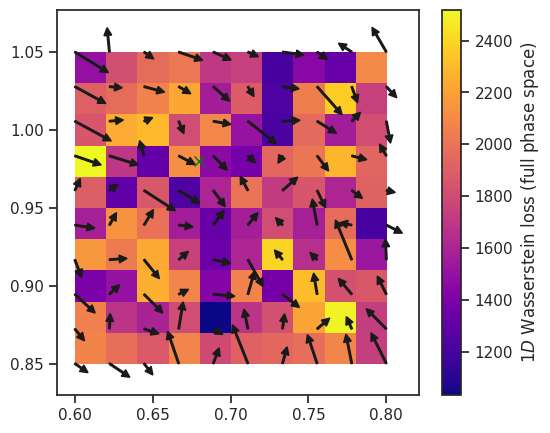

In [143]:
# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)

fig, ax = plt.subplots(1,1,figsize=(6,5))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.plasma  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape).T

# Create a heatmap of the gradient magnitudes
#heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))
heatmap = ax.imshow((loss_grid * N_events).reshape(grid_shape).T, cmap=cmap, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))

# Add a colorbar to show the magnitude scale
#fig.colorbar(heatmap, ax=ax, label=r'$|\vec{\nabla}_\theta \mathcal{L}|$')
fig.colorbar(heatmap, ax=ax, label=r'$1D$ Wasserstein loss (full phase space)')

# Plot arrows for each point and direction
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], -gradient[0]/1e0, -gradient[1]/1e0, head_width=0.005, head_length=0.005, fc='k', ec='k')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='green', label = 'Target', ms = 7, linewidth=10)#label = r'$\mathrm{Target}$')
